In [1]:
import torch
import torch.nn as nn
import gym
import numpy as np
import random
import torch.nn.functional as F
from ops import *
from models import *
%matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import functools
import math

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2','LunarLander-v2']
env_to_use = 0

discrete_actions = True

env = gym.make(envs[env_to_use]).unwrapped
if discrete_actions:
    creature_out_size = env.action_space.n
else:
    creature_out_size = env.action_space.shape[0]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



In [2]:
def train_gan(pop,p_fitness,population_size,batch_size = 20,n_epochs = 100):
    p_fitness = torch.from_numpy(p_fitness).type("torch.FloatTensor").to(device)
    
    gen_explore_all = []
    gen_exploit_all = []
    dis_loss_all = []
    dis_confidence_all = []
    gen_all_lr=[]
    for e in range(n_epochs):
        #shuffle arrays in unison
        #ind = np.arange(population_size)
        #np.random.shuffle(ind)
        #pop = pop[ind]
        #p_fitness = p_fitness[ind]
        for i in range(population_size//batch_size):
            #turn population into vectors
            p_batch = pop[i*batch_size:(i*batch_size)+batch_size].detach()
            f_batch = p_fitness[i*batch_size:(i*batch_size)+batch_size].detach()
            
            #train discriminator on population
            dis_optimizer.zero_grad()
            
            dis_out_r,_ = dis(p_batch)
            dis_out_r = dis_out_r.squeeze(-1)
            
            dis_error_real = (torch.pow((dis_out_r[...,0]-f_batch),2))
            dis_error_real_mean = torch.mean(dis_error_real)
            dis_error_real_mean.backward(retain_graph=True)
            
            #discriminator confidence in its prediction
            dis_confidence = torch.mean(torch.pow(dis_out_r[...,1]-dis_error_real.detach(),2))
            dis_confidence.backward()
            
            dis_optimizer.step() 
            dis_loss_all.append(dis_error_real_mean)  
            dis_confidence_all.append(torch.mean(dis_out_r[...,1]))
            
        #if False:
        for i in range(population_size//batch_size):
            gen.hidden = None
            gen_optimizer.zero_grad()
            gen_out,gen_lr = gen(p_batch)
            
            
            dis_out_f,dis_out_latent = dis(p_batch + gen_out)
            
            #define generator loss
            variety = 0-torch.mean(torch.std(F.tanh(dis_out_latent),-1))#-torch.std(dis_out_f[...,0])*0.01#
            surprise = -torch.mean(dis_out_f[...,1]) 
            gen_error_exploration = (variety) + surprise
            gen_error_exploitation = -torch.mean(dis_out_f[...,0]) + torch.mean(torch.pow(gen_out,2))#torch.mean(torch.abs(gen_out))
            gen_error =  gen_error_exploitation + gen_error_exploration#*0.5
            
            gen_error.backward()
            gen_optimizer.step() 
            
            gen_all_lr.append(torch.mean(gen_lr))
            gen_explore_all.append(gen_error_exploration)
            gen_exploit_all.append(gen_error_exploitation)
            gen.hidden = None
            
    print(f_batch)
    print(dis_out_r[...,0])   
    
    return gen_explore_all,gen_exploit_all, dis_loss_all,dis_confidence_all,gen_all_lr

starting training
386
Measured population fitness : 0s
population fitness : [ 9. 10. 10. 10. 10. 10.  8.  8. 10. 23.]
mean fit : 10.8


/home/liam/.local/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor([0.3930, 0.4519, 0.4519, 0.4519, 0.4519, 0.4519, 0.3372, 0.3372, 0.4519,
        0.9500], device='cuda:0')
tensor([0.4395, 0.4374, 0.4398, 0.4394, 0.4426, 0.4403, 0.4431, 0.4359, 0.4405,
        0.4474], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


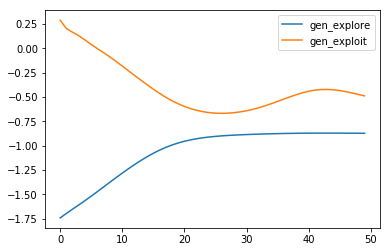

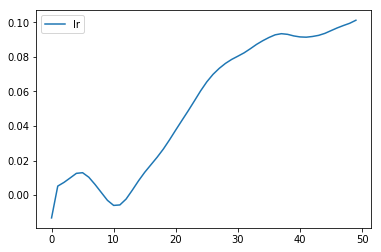

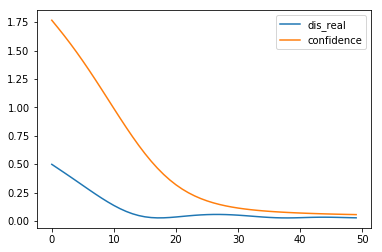

Generation 1  fitness : 23.0
#################################
Measured population fitness : 0s
population fitness : [ 9.  9. 10. 10. 10.  9.  9.  9. 11.  9.]
mean fit : 9.5
tensor([0.4065, 0.4877, 0.4877, 0.4877, 0.4877, 0.4877, 0.3301, 0.3301, 0.4877,
        0.9857, 0.4065, 0.4065, 0.4877, 0.4877, 0.4877, 0.4065, 0.4065, 0.4065,
        0.5695, 0.4065], device='cuda:0')
tensor([0.4408, 0.4605, 0.4681, 0.4726, 0.4757, 0.4518, 0.4376, 0.4404, 0.4763,
        0.5389, 0.4408, 0.4605, 0.4681, 0.4726, 0.4757, 0.4518, 0.4376, 0.4404,
        0.4763, 0.5389], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


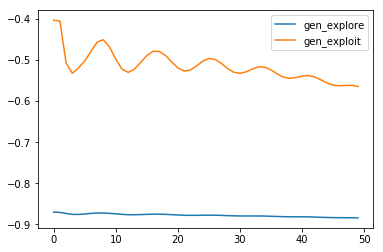

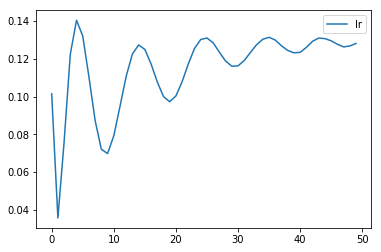

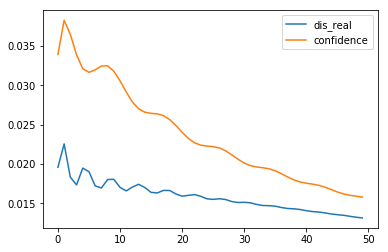

Generation 2  fitness : 11.0
#################################
Measured population fitness : 0s
population fitness : [ 9. 10.  9. 10. 10. 11.  8.  9.  9.  9.]
mean fit : 9.4
tensor([0.3525, 0.3525, 0.6777, 0.6777, 0.6777, 0.3525, 0.3525, 0.3525, 0.8904,
        0.3525, 0.3525, 0.6777, 0.3525, 0.6777, 0.6777, 0.8904, 0.1235, 0.3525,
        0.3525, 0.3525], device='cuda:0')
tensor([0.4133, 0.4850, 0.4966, 0.5315, 0.5290, 0.5196, 0.3768, 0.4269, 0.5315,
        0.4829, 0.4133, 0.4850, 0.4966, 0.5315, 0.5290, 0.5196, 0.3768, 0.4269,
        0.5315, 0.4829], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


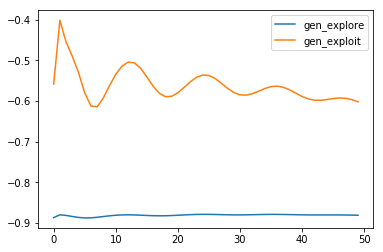

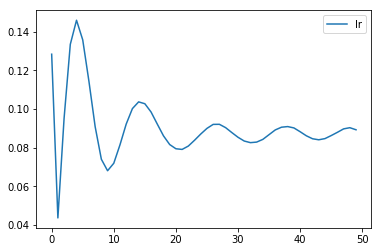

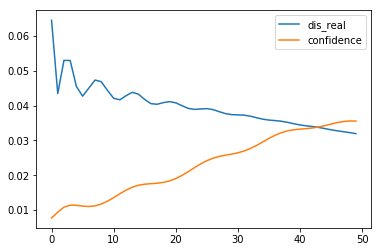

Generation 3  fitness : 11.0
#################################
Measured population fitness : 0s
population fitness : [ 9.  9.  9. 10. 11. 10.  9.  9.  9. 10.]
mean fit : 9.5
tensor([0.3525, 0.6777, 0.3525, 0.6777, 0.6777, 0.8904, 0.1235, 0.3525, 0.3525,
        0.3525, 0.3525, 0.3525, 0.3525, 0.6777, 0.8904, 0.6777, 0.3525, 0.3525,
        0.3525, 0.6777], device='cuda:0')
tensor([0.4061, 0.5000, 0.4291, 0.5846, 0.6489, 0.6336, 0.3130, 0.3678, 0.4138,
        0.4602, 0.4061, 0.5000, 0.4291, 0.5846, 0.6489, 0.6336, 0.3130, 0.3678,
        0.4138, 0.4602], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


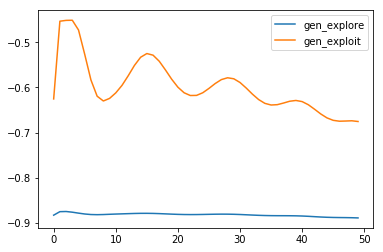

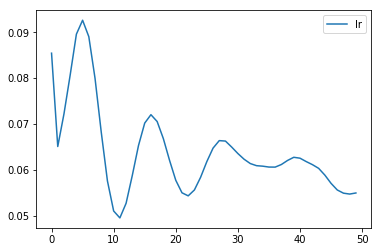

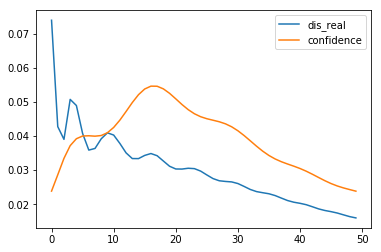

Generation 4  fitness : 11.0
#################################
Measured population fitness : 0s
population fitness : [10. 10. 10. 10. 15.  9. 10. 10. 10. 10.]
mean fit : 10.4
tensor([0.3230, 0.3230, 0.3230, 0.5097, 0.6938, 0.5097, 0.3230, 0.3230, 0.3230,
        0.5097, 0.5097, 0.5097, 0.5097, 0.5097, 0.9808, 0.3230, 0.5097, 0.5097,
        0.5097, 0.5097], device='cuda:0')
tensor([0.4156, 0.4415, 0.4096, 0.5127, 0.6490, 0.4906, 0.3925, 0.4047, 0.4088,
        0.4701, 0.4156, 0.4415, 0.4096, 0.5127, 0.6490, 0.4906, 0.3925, 0.4047,
        0.4088, 0.4701], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


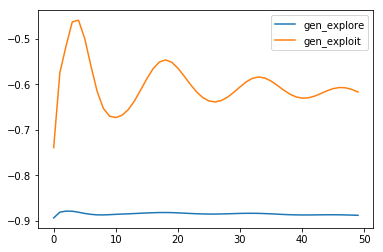

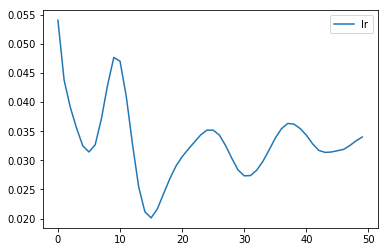

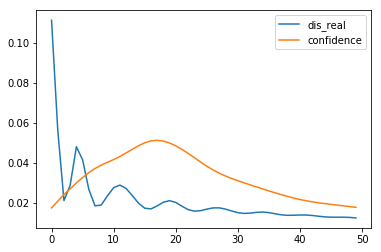

Generation 5  fitness : 15.0
#################################
Measured population fitness : 0s
population fitness : [ 8.  9. 10. 10. 13. 10.  8. 10. 10. 10.]
mean fit : 9.8
tensor([0.4831, 0.4831, 0.4831, 0.4831, 0.9648, 0.3223, 0.4831, 0.4831, 0.4831,
        0.4831, 0.1948, 0.3223, 0.4831, 0.4831, 0.8765, 0.4831, 0.1948, 0.4831,
        0.4831, 0.4831], device='cuda:0')
tensor([0.3871, 0.4174, 0.4747, 0.5113, 0.7460, 0.4077, 0.3883, 0.4470, 0.4751,
        0.4837, 0.3871, 0.4174, 0.4747, 0.5113, 0.7460, 0.4077, 0.3883, 0.4470,
        0.4751, 0.4837], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


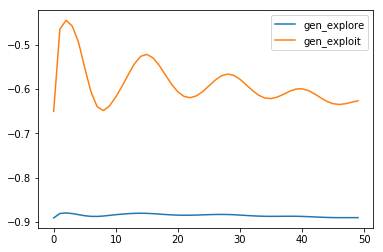

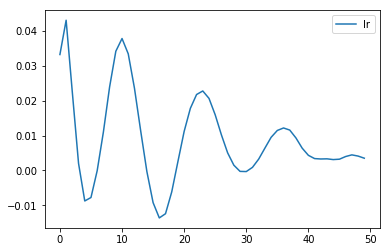

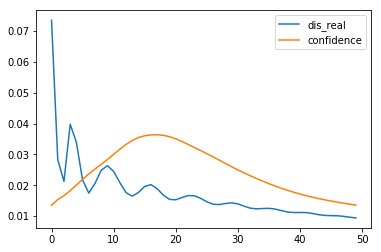

Generation 6  fitness : 13.0
#################################
Measured population fitness : 0s
population fitness : [10. 11. 10. 10. 26.  9.  9. 11.  9. 10.]
mean fit : 11.5
tensor([0.3273, 0.3897, 0.4559, 0.4559, 0.6545, 0.4559, 0.3273, 0.4559, 0.4559,
        0.4559, 0.4559, 0.5238, 0.4559, 0.4559, 0.9848, 0.3897, 0.3897, 0.5238,
        0.3897, 0.4559], device='cuda:0')
tensor([0.4032, 0.4426, 0.4639, 0.4678, 0.7358, 0.4238, 0.3749, 0.4527, 0.4294,
        0.4516, 0.4032, 0.4426, 0.4639, 0.4678, 0.7358, 0.4238, 0.3749, 0.4527,
        0.4294, 0.4516], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


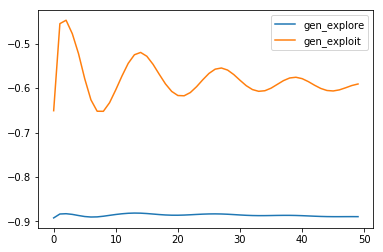

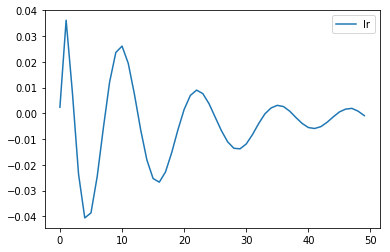

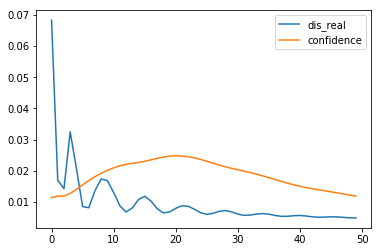

Generation 7  fitness : 26.0
#################################
Measured population fitness : 0s
population fitness : [10.  9.  9. 10. 12. 12. 10. 10.  8. 10.]
mean fit : 10.0
tensor([0.4486, 0.5172, 0.4486, 0.4486, 0.9852, 0.3818, 0.3818, 0.5172, 0.3818,
        0.4486, 0.4486, 0.3818, 0.3818, 0.4486, 0.5852, 0.5852, 0.4486, 0.4486,
        0.3192, 0.4486], device='cuda:0')
tensor([0.4546, 0.4442, 0.4187, 0.4480, 0.7423, 0.4880, 0.4217, 0.4641, 0.3446,
        0.4434, 0.4546, 0.4442, 0.4187, 0.4480, 0.7423, 0.4880, 0.4217, 0.4641,
        0.3446, 0.4434], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


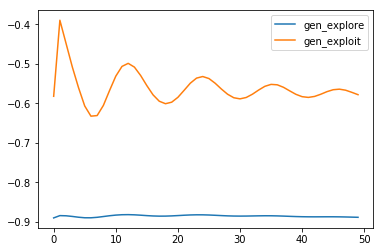

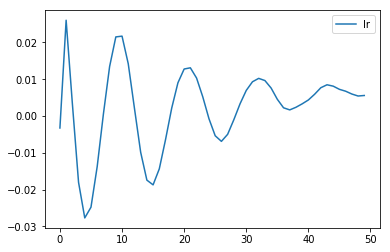

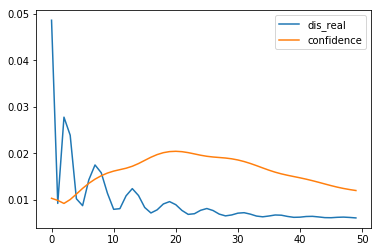

Generation 8  fitness : 12.0
#################################
Measured population fitness : 0s
population fitness : [10.  9.  9.  8.  9. 16.  9. 11.  9. 12.]
mean fit : 10.2
tensor([0.4860, 0.3507, 0.3507, 0.4860, 0.7434, 0.7434, 0.4860, 0.4860, 0.2358,
        0.4860, 0.4860, 0.3507, 0.3507, 0.2358, 0.3507, 0.9645, 0.3507, 0.6234,
        0.3507, 0.7434], device='cuda:0')
tensor([0.4897, 0.3506, 0.3770, 0.3545, 0.6868, 0.7514, 0.4513, 0.5459, 0.3077,
        0.5955, 0.4897, 0.3506, 0.3770, 0.3545, 0.6868, 0.7514, 0.4513, 0.5459,
        0.3077, 0.5955], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


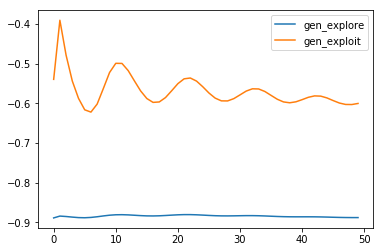

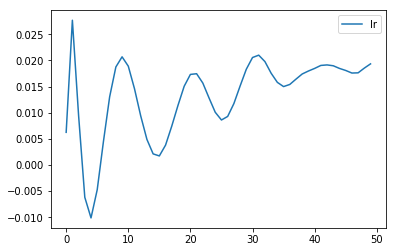

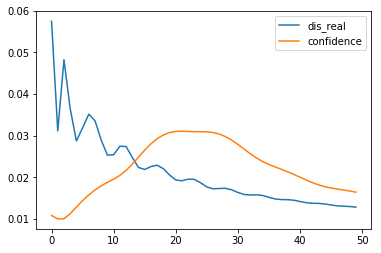

Generation 9  fitness : 16.0
#################################
Measured population fitness : 0s
population fitness : [ 8. 17. 10.  9. 11. 18. 10. 11. 13. 17.]
mean fit : 12.4
tensor([0.3972, 0.3234, 0.3234, 0.2575, 0.3234, 0.8188, 0.3234, 0.4759, 0.3234,
        0.5559, 0.2575, 0.8617, 0.3972, 0.3234, 0.4759, 0.8957, 0.3972, 0.4759,
        0.6331, 0.8617], device='cuda:0')
tensor([0.3279, 0.5892, 0.3901, 0.2903, 0.4802, 0.7706, 0.3745, 0.5127, 0.4975,
        0.6783, 0.3279, 0.5892, 0.3901, 0.2903, 0.4802, 0.7706, 0.3745, 0.5127,
        0.4975, 0.6783], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


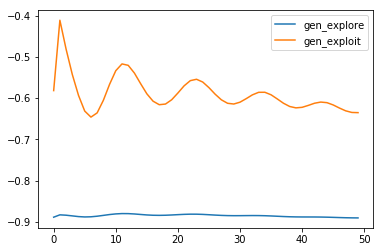

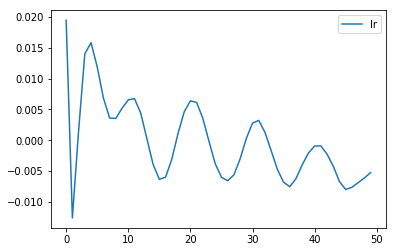

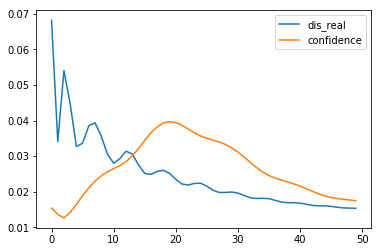

Generation 10  fitness : 18.0
#################################
Measured population fitness : 0s
population fitness : [  16.   36.    8.    9.   16.   16.    9. 2000.    9.   13.]
mean fit : 213.2
tensor([0.4398, 0.4449, 0.4409, 0.4404, 0.4415, 0.4455, 0.4409, 0.4415, 0.4426,
        0.4449, 0.4443, 0.4558, 0.4398, 0.4404, 0.4443, 0.4443, 0.4404, 0.9874,
        0.4404, 0.4426], device='cuda:0')
tensor([0.4061, 0.4708, 0.4387, 0.4393, 0.3877, 0.4845, 0.4250, 0.6580, 0.4151,
        0.4808, 0.4061, 0.4708, 0.4387, 0.4393, 0.3877, 0.4845, 0.4250, 0.6580,
        0.4151, 0.4808], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


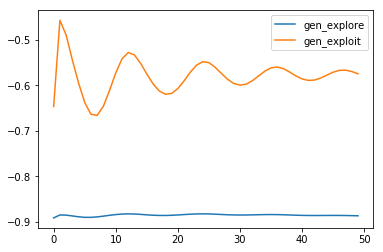

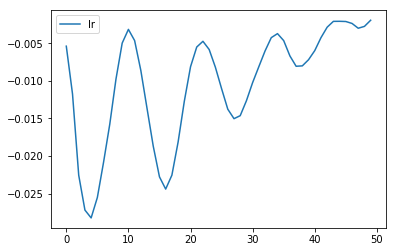

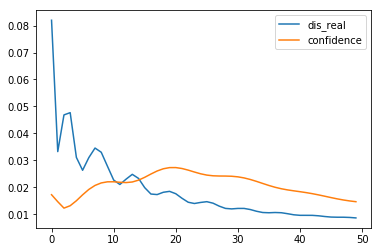

Generation 11  fitness : 2000.0
#################################
Measured population fitness : 0s
population fitness : [23. 26. 10. 10. 22. 39. 20. 12.  9.  9.]
mean fit : 18.0
tensor([0.4427, 0.4541, 0.4381, 0.4387, 0.4427, 0.4427, 0.4387, 0.9874, 0.4387,
        0.4410, 0.4467, 0.4484, 0.4392, 0.4392, 0.4461, 0.4558, 0.4450, 0.4404,
        0.4387, 0.4387], device='cuda:0')
tensor([0.4582, 0.4633, 0.4520, 0.4517, 0.4508, 0.4572, 0.4589, 0.7052, 0.4529,
        0.4494, 0.4582, 0.4633, 0.4520, 0.4517, 0.4508, 0.4572, 0.4589, 0.7052,
        0.4529, 0.4494], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


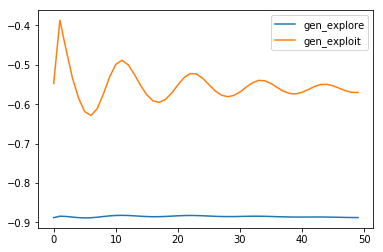

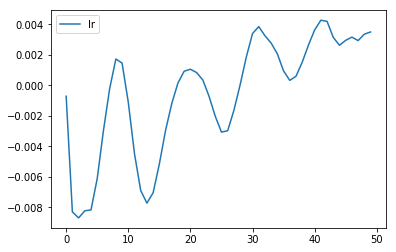

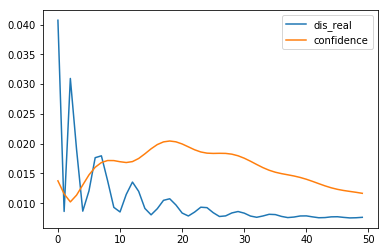

Generation 12  fitness : 39.0
#################################
Measured population fitness : 0s
population fitness : [53. 34.  9. 11. 33. 29. 21. 10. 13.  9.]
mean fit : 22.2
tensor([0.5597, 0.6196, 0.3025, 0.3025, 0.5392, 0.8268, 0.4979, 0.3385, 0.2854,
        0.2854, 0.9383, 0.7594, 0.2854, 0.3202, 0.7440, 0.6761, 0.5186, 0.3025,
        0.3573, 0.2854], device='cuda:0')
tensor([0.7566, 0.6917, 0.2829, 0.3057, 0.6861, 0.7716, 0.4927, 0.3169, 0.3138,
        0.2940, 0.7566, 0.6917, 0.2829, 0.3057, 0.6861, 0.7716, 0.4927, 0.3169,
        0.3138, 0.2940], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


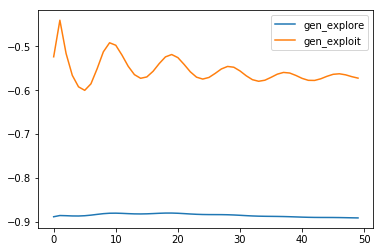

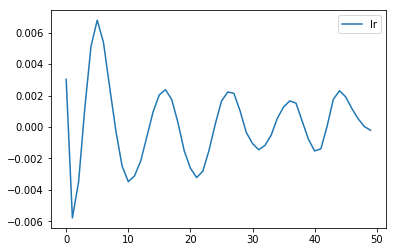

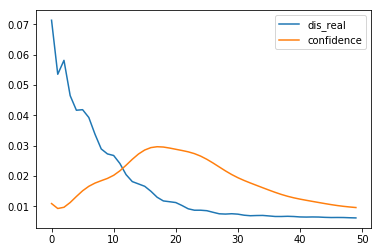

Generation 13  fitness : 53.0
#################################
Measured population fitness : 0s
population fitness : [103.  43.   9.   9.  39.  52.   9.   9. 110.  10.]
mean fit : 39.3
tensor([0.6812, 0.5277, 0.3226, 0.3376, 0.5192, 0.4851, 0.4176, 0.3301, 0.3531,
        0.3226, 0.9216, 0.6030, 0.3226, 0.3226, 0.5699, 0.6737, 0.3226, 0.3226,
        0.9372, 0.3301], device='cuda:0')
tensor([0.7623, 0.5842, 0.3061, 0.3251, 0.5471, 0.5868, 0.3414, 0.3328, 0.6212,
        0.3274, 0.7623, 0.5842, 0.3061, 0.3251, 0.5471, 0.5868, 0.3414, 0.3328,
        0.6212, 0.3274], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


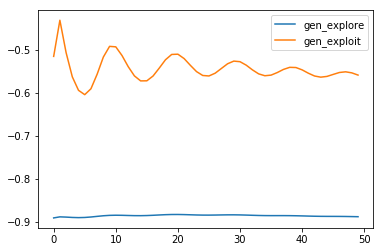

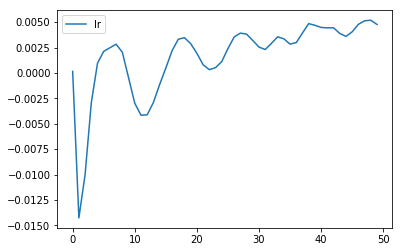

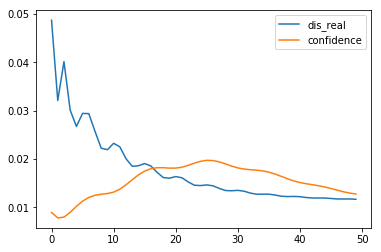

Generation 14  fitness : 110.0
#################################
Measured population fitness : 0s
population fitness : [169. 587.  10.  10.  25.  90.  26.   8.   8.  10.]
mean fit : 94.3
tensor([0.5707, 0.4533, 0.3882, 0.3882, 0.4455, 0.4709, 0.3882, 0.3882, 0.5842,
        0.3901, 0.6909, 0.9836, 0.3901, 0.3901, 0.4185, 0.5455, 0.4204, 0.3863,
        0.3863, 0.3901], device='cuda:0')
tensor([0.6481, 0.6937, 0.3840, 0.3774, 0.4260, 0.4935, 0.4063, 0.3740, 0.4825,
        0.3718, 0.6481, 0.6937, 0.3840, 0.3774, 0.4260, 0.4935, 0.4063, 0.3740,
        0.4825, 0.3718], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


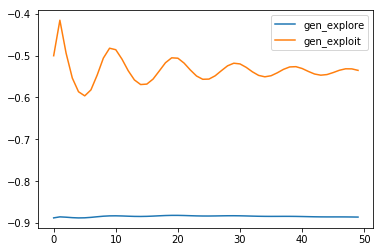

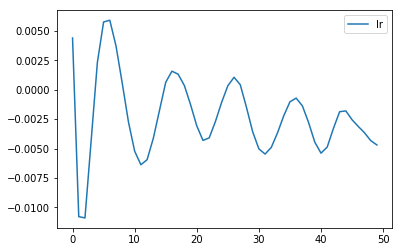

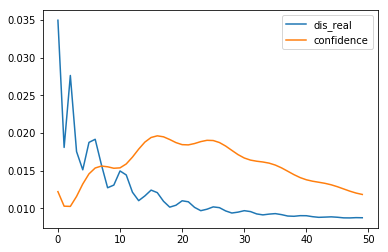

Generation 15  fitness : 587.0
#################################
Measured population fitness : 0s
population fitness : [55. 44.  9. 10. 26. 52. 56. 10. 10.  8.]
mean fit : 28.0


KeyboardInterrupt: 

In [4]:
population = []
max_population_batch = 2
n_generations = 300
population_size = 10

creat = Creature(env.observation_space.shape[0],creature_out_size).to(device)
for p in range(population_size):
    creat = Creature(env.observation_space.shape[0],creature_out_size).to(device)

    #pars = torch.from_numpy(np.random.uniform(0,1,get_params(creat).numel())).type('torch.FloatTensor').to(device)
    pars = torch.tanh(get_params(creat))
    pars = get_params(creat)
    creat = set_params(creat,pars)
    population.append(creat)
    
print("starting training")
creature_size = len(get_params(Creature(env.observation_space.shape[0],creature_out_size)))
print(creature_size)

old_population = []
old_fitnesses = []
all_fitnesses = []

gen = Generator(creature_size,device,population_size).to(device)
dis = Discriminator().to(device)


for i in range(n_generations):
    start_time = time.time()
    
    #reset learning rate decay after every generation
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0001,betas=(0.9,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.0001,betas=(0.9,0.999))
    
    #calculate population fitness
    p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)
    print("Measured population fitness : {}s".format(int(time.time() - start_time)))
    
    #Store populations and remove older ones
    old_population.append(population)
    old_fitnesses.append(p_fitness_)
    all_fitnesses.append(p_fitness_)
    
    if len(old_population) > max_population_batch:
        old_population.pop(0)
        old_fitnesses.pop(0)
    
    print("population fitness : {}".format(p_fitness_))
    print("mean fit : {}".format(np.mean(p_fitness_)))   
    
    #define population batch
    population_concat = np.concatenate(np.array(old_population))
    population_batch = []
    for p in population_concat:
        #print(get_params(p))
        population_batch.append(get_params(p))
    population_batch = torch.stack(population_batch, dim=0).to(device)
    
    #define fitness batch
    fitness_batch = np.concatenate(np.array(old_fitnesses))
    fitness_batch_normed = (fitness_batch - np.mean(fitness_batch))/(np.std(fitness_batch)+0.000001)
    #fitness_batch_normed = (fitness_batch -  np.min(fitness_batch))/(np.max(fitness_batch)-np.min(fitness_batch))
    #fitness_batch_normed = np.log(np.abs(fitness_batch_normed)+1) * (fitness_batch_normed/np.abs(fitness_batch_normed))
    fitness_batch_normed = 1 / (1+ np.exp(-fitness_batch_normed))
    
    #Train GAN
    start_time = time.time()
    n_epochs = 50
    if i == 0:
        n_epochs = 50
        
    gen_explore_all,gen_exploit_all, dis_loss ,dis_confidence_all,gen_all_lr= train_gan(population_batch
                                                                                       ,fitness_batch_normed,
              fitness_batch.size,batch_size = fitness_batch.size,n_epochs = n_epochs)
    
    print("Trained GAN : {}s".format(int(time.time() - start_time)))
    
    #Every ten generations show progress
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 500)
        
    
    #print(population_batch[population_batch.size(0)  - population_size:].shape,population_batch.shape)
    mutations,gen_lr = gen(population_batch[population_batch.size(0)  - population_size:])
    gen.hidden = None
    
    #Apply mutations
    for idx,p in enumerate(population_batch[population_batch.size(0) - population_size:]):
        child = Creature(env.observation_space.shape[0],creature_out_size) 
        population[idx] = set_params(child,p + mutations[idx])
    
    
    
    plt.plot(gen_explore_all,label='gen_explore')
    plt.plot(gen_exploit_all,label='gen_exploit')
    plt.legend()
    plt.show()
    plt.plot(gen_all_lr,label='lr')
    plt.legend()
    plt.show()
    plt.plot(dis_loss,label='dis_real')
    plt.plot(dis_confidence_all,label='confidence')
    #plt.ylim(0,5)
    plt.legend()
    plt.show()
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness_)))
    print("#################################")